In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import random
import cooler
import cooltools
import cooltools.lib.plotting
from cooltools.insulation import calculate_insulation_score, find_boundaries
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid import make_axes_locatable
import bioframe
from skimage.filters import threshold_li, threshold_otsu
import bbi
import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/DATA/users/magnitov/software/anaconda3/lib/python3.8/site-packages/cooltools/lib/numutils.py:11: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from ._numutils import (
/tmp/ipykernel_975524/1480445538.py:13: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid import make_axes_locatable


## Find optimal window for insulation score using merged dataset

In [2]:
# Functions to help with plotting
def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
    im.set_rasterized(True)
    return im

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [7]:
clr = cooler.Cooler('/DATA/users/magnitov/tacl/hic/coolers/haarhuis_2017.WT.hg38.mapq_30.1000.mcool::/resolutions/10000')
windows = [100000, 200000, 300000]
insulation = calculate_insulation_score(clr, windows, chromosomes = ['chr5'], verbose=True)

INFO:root:Processing chr5


In [8]:
insulation.iloc[1000:1005]

,chrom,start,end,is_bad_bin,log2_insulation_score_100000,n_valid_pixels_100000,log2_insulation_score_200000,n_valid_pixels_200000,log2_insulation_score_300000,n_valid_pixels_300000
88968,chr5,10000000,10010000,False,-0.001369,97.0,0.048816,397.0,-0.030355,897.0
88969,chr5,10010000,10020000,False,-0.042481,97.0,0.030658,397.0,-0.065853,897.0
88970,chr5,10020000,10030000,False,-0.062635,97.0,0.022348,397.0,-0.098646,897.0
88971,chr5,10030000,10040000,False,-0.089915,97.0,0.003460,397.0,-0.116819,897.0
88972,chr5,10040000,10050000,False,-0.127465,97.0,-0.001826,397.0,-0.156022,897.0


(127000000.0, 131000000.0)

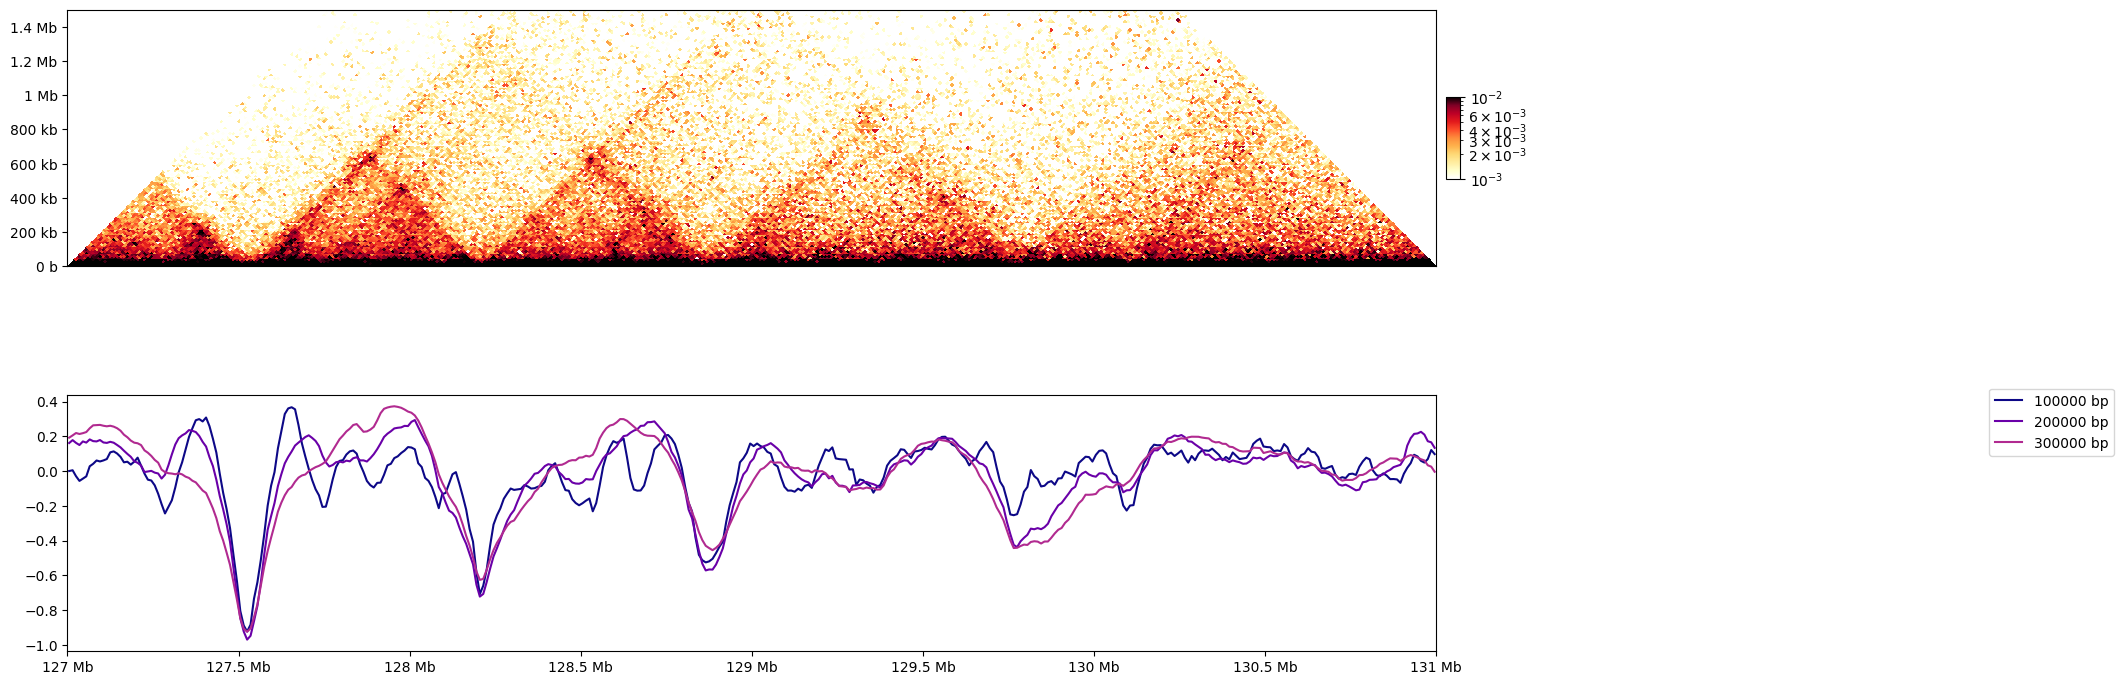

In [9]:
region = ('chr5', 127_000_000, 131_000_000)
norm = LogNorm(vmax=0.01, vmin=0.001)
data = clr.matrix(balance=True).fetch(region)

f, ax = plt.subplots(figsize=(25, 10))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=10000, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 1500000)
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation, region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)
ins_ax.set_prop_cycle(plt.cycler("color", plt.cm.plasma(np.linspace(0,1,6))))

for res in [100000, 200000, 300000]:
    ins_ax.plot(insul_region[['start', 'end']].mean(axis=1), insul_region[f'log2_insulation_score_{res}'], label=f'{res} bp')
ins_ax.legend(bbox_to_anchor=(1.5, 1.05), loc='upper right')

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])

### Select cutoff for TAD boundaries

In [10]:
insulation = find_boundaries(insulation)

In [11]:
insulation.iloc[1000:1005]

,chrom,start,end,is_bad_bin,log2_insulation_score_100000,n_valid_pixels_100000,log2_insulation_score_200000,n_valid_pixels_200000,log2_insulation_score_300000,n_valid_pixels_300000,boundary_strength_100000,boundary_strength_200000,boundary_strength_300000
1000,chr5,10000000,10010000,False,-0.001369,97.0,0.048816,397.0,-0.030355,897.0,NaN,NaN,NaN
1001,chr5,10010000,10020000,False,-0.042481,97.0,0.030658,397.0,-0.065853,897.0,NaN,NaN,NaN
1002,chr5,10020000,10030000,False,-0.062635,97.0,0.022348,397.0,-0.098646,897.0,NaN,NaN,NaN
1003,chr5,10030000,10040000,False,-0.089915,97.0,0.003460,397.0,-0.116819,897.0,NaN,NaN,NaN
1004,chr5,10040000,10050000,False,-0.127465,97.0,-0.001826,397.0,-0.156022,897.0,NaN,NaN,NaN


In [12]:
thresholds_li = {}
thresholds_otsu = {}
for w in windows:
    thresholds_li[w] = threshold_li(insulation[f'boundary_strength_{w}'].dropna().values)
    thresholds_otsu[w] = threshold_otsu(insulation[f'boundary_strength_{w}'].dropna().values)

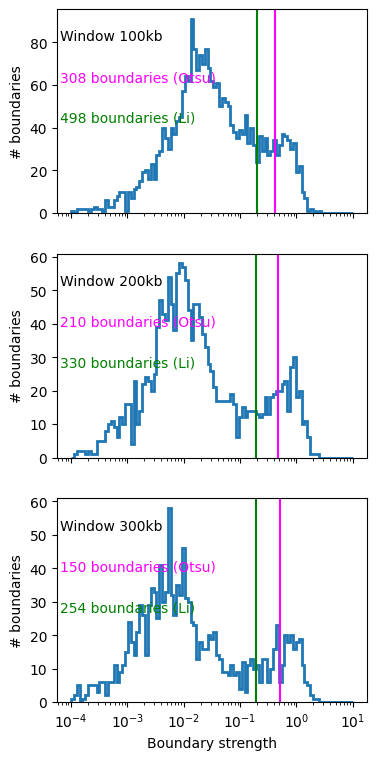

In [16]:
histkwargs = dict(
    bins=10**np.linspace(-4,1,100),
    histtype='step',
    lw=2,
)

f, axs = plt.subplots(len(windows), 1, sharex=True, figsize=(4,9))

for i, (w, ax) in enumerate(zip(windows, axs)):
    ax.hist(
        insulation[f'boundary_strength_{w}'],
        **histkwargs
    )
    n_boundaries_li = (insulation[f'boundary_strength_{w}'].dropna()>=thresholds_li[w]).sum()
    n_boundaries_otsu = (insulation[f'boundary_strength_{w}'].dropna()>=thresholds_otsu[w]).sum()
    ax.axvline(thresholds_li[w], c='green')
    ax.axvline(thresholds_otsu[w], c='magenta')
    ax.text(0.01, 0.9,
             f'Window {w//1000}kb',
             ha='left',
             va='top',
             transform=ax.transAxes)
    ax.text(0.01, 0.7,
            f'{n_boundaries_otsu} boundaries (Otsu)',
            c='magenta',
            ha='left',
            va='top',
            transform=ax.transAxes)
    ax.text(0.01, 0.5,
            f'{n_boundaries_li} boundaries (Li)',
            c='green',
            ha='left',
            va='top',
            transform=ax.transAxes)

    ax.set(
        xscale='log',
        ylabel='# boundaries'
    )

axs[-1].set(xlabel='Boundary strength');

(127000000.0, 131000000.0)

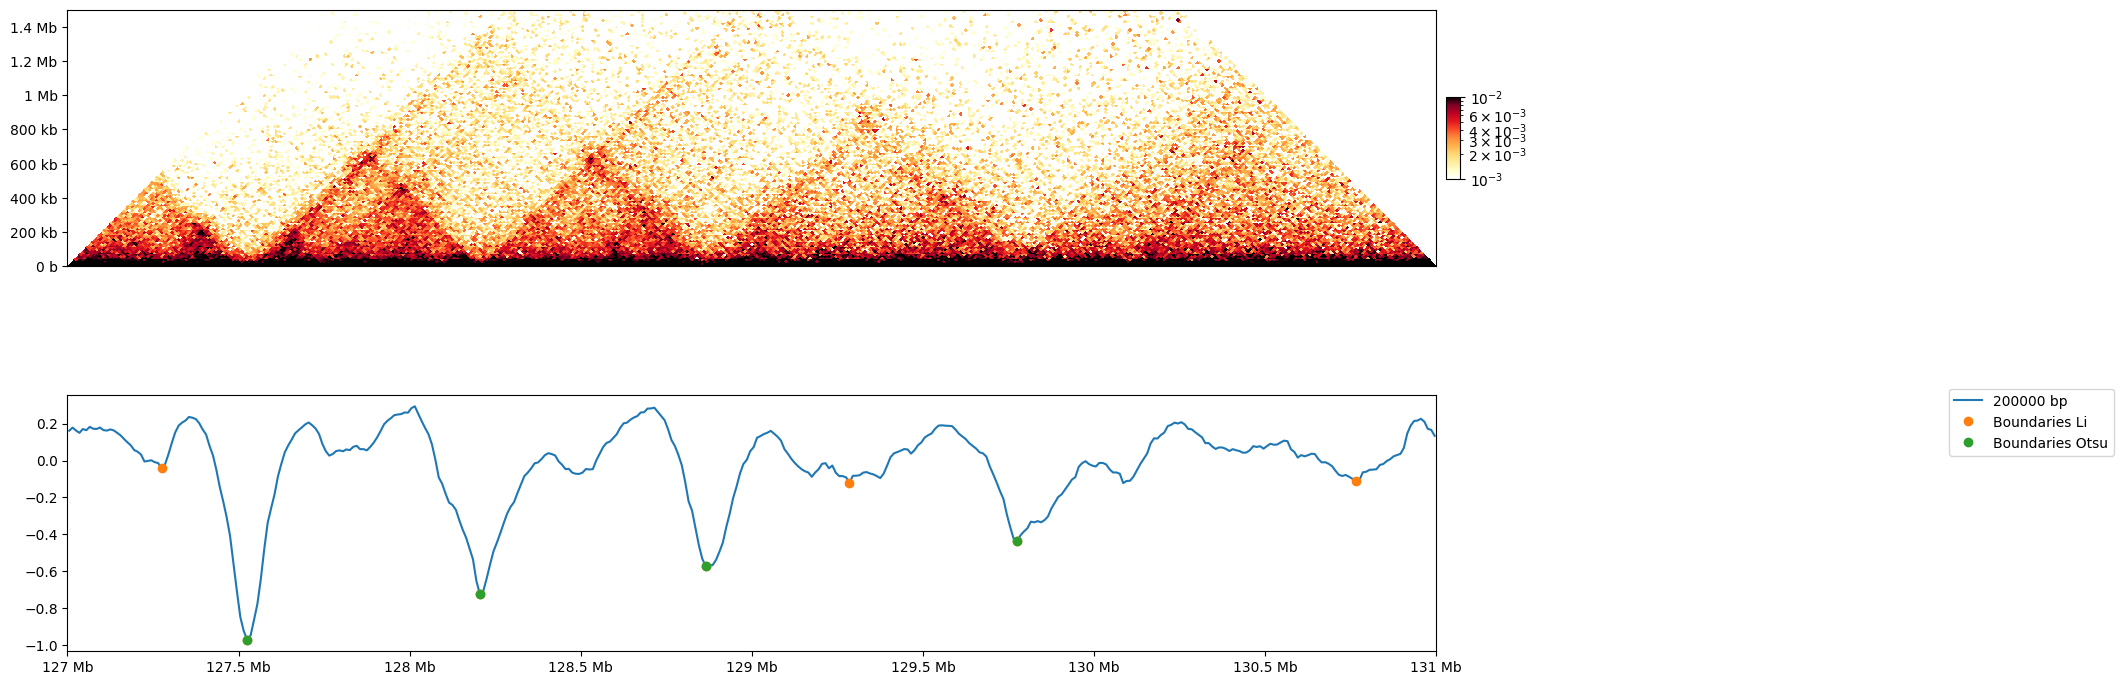

In [17]:
res = 200000
region = ('chr5', 127_000_000, 131_000_000)
norm = LogNorm(vmax=0.01, vmin=0.001)
data = clr.matrix(balance=True).fetch(region)

f, ax = plt.subplots(figsize=(25, 10))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=10000, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 1500000)
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation, region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)

ins_ax.plot(insul_region[['start', 'end']].mean(axis=1), insul_region[f'log2_insulation_score_{res}'], label=f'{res} bp')
#boundaries = insul_region[~np.isnan(insul_region[f'boundary_strength_{res}'])]
#ins_ax.plot(boundaries[['start', 'end']].mean(axis=1), boundaries[f'log2_insulation_score_{res}'], 'o', label='Boundaries')
boundaries = insul_region[insul_region[f'boundary_strength_{res}'] >=thresholds_li[res]]
ins_ax.plot(boundaries[['start', 'end']].mean(axis=1), boundaries[f'log2_insulation_score_{res}'], 'o', label='Boundaries Li')
boundaries = insul_region[insul_region[f'boundary_strength_{res}'] >=thresholds_otsu[res]]
ins_ax.plot(boundaries[['start', 'end']].mean(axis=1), boundaries[f'log2_insulation_score_{res}'], 'o', label='Boundaries Otsu')

ins_ax.legend(bbox_to_anchor=(1.5, 1.05), loc='upper right')

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])

## Calculate TAD boundaries and TADs for the whole genome

In [19]:
clr = cooler.Cooler('/DATA/users/magnitov/tacl/hic/coolers/haarhuis_2017.WT.hg38.mapq_30.1000.mcool::/resolutions/10000')
window = 200000
insulation = calculate_insulation_score(clr, [window], verbose=True)

insulation = find_boundaries(insulation)

thresholds_li = {}
thresholds_li[window] = threshold_li(insulation[f'boundary_strength_{window}'].dropna().values)
    
significant_borders = insulation[insulation[f'boundary_strength_{window}'] >= thresholds_li[window]]
significant_borders = significant_borders[significant_borders['is_bad_bin'] == False]
significant_borders.head()

INFO:root:Processing chr1
INFO:root:Processing chr2
INFO:root:Processing chr3
INFO:root:Processing chr4
INFO:root:Processing chr5
INFO:root:Processing chr6
INFO:root:Processing chr7
INFO:root:Processing chr8
INFO:root:Processing chr9
INFO:root:Processing chr10
INFO:root:Processing chr11
INFO:root:Processing chr12
INFO:root:Processing chr13
INFO:root:Processing chr14
INFO:root:Processing chr15
INFO:root:Processing chr16
INFO:root:Processing chr17
INFO:root:Processing chr18
INFO:root:Processing chr19
INFO:root:Processing chr20
INFO:root:Processing chr21
INFO:root:Processing chr22
INFO:root:Processing chrX
INFO:root:Processing chrY
INFO:root:Processing chrM


,chrom,start,end,is_bad_bin,log2_insulation_score_200000,n_valid_pixels_200000,boundary_strength_200000
101,chr1,1010000,1020000,False,0.374155,337.0,0.566647
130,chr1,1300000,1310000,False,0.173465,397.0,0.485141
191,chr1,1910000,1920000,False,-0.197284,397.0,0.660438
300,chr1,3000000,3010000,False,0.184033,397.0,0.477646
342,chr1,3420000,3430000,False,-0.374442,397.0,0.739378


In [20]:
significant_borders[['chrom', 'start', 'end']].to_csv('haarhuis_2017.WT.insulation_boundaries_200kb.bed', sep = '\t', header = 0, index = 0)

In [21]:
chrom_sizes = pd.read_csv('/DATA/users/magnitov/genomes/hg38.chrom.sizes', sep = '\t', header = None)

tads = []
for chromosome in np.unique(significant_borders['chrom']):
    cbs = significant_borders[significant_borders['chrom'] == chromosome]
    for i in range(0, len(cbs)):
        if i == 0:
            end = cbs.values[i][1:3][random.randint(0, 1)]
            tads.append([chromosome, 0, end])
        elif i == len(cbs)-1:
            start = end
            tads.append([chromosome, end, chrom_sizes[chrom_sizes[0] == chromosome][1].values[0]])
        else:
            start = end
            end = cbs.values[i][1:3][random.randint(0, 1)]
            tads.append([chromosome, start, end])
            
tads = pd.DataFrame(tads)

In [22]:
tads.to_csv('haarhuis_2017.WT.tads_200kb.bed', sep = '\t', header = 0, index = 0)

## Average insulation boundary

In [156]:
def get_boundary_strength(pile):
    intra_tad = [x for x in np.hstack((pile[:50, :50].flatten(), pile[51:, 51:].flatten())) if x != 0]
    inter_tad = [x for x in np.hstack((pile[51:, :50].flatten(), pile[:50, 51:].flatten())) if x != 0]
    boundary_strength = np.mean(intra_tad)/np.mean(inter_tad)
    return(str(round(boundary_strength, 2)))

In [157]:
pile1 = pd.read_csv('./insulation/average_insulation_borders_T-MAU2.txt', skiprows = 35, sep = '\s+', header = None).values
pile2 = pd.read_csv('./insulation/average_insulation_borders_T-MAU2_Dox_1H.txt', skiprows = 35, sep = '\s+', header = None).values
pile3 = pd.read_csv('./insulation/average_insulation_borders_T-mCherry.txt', skiprows = 35, sep = '\s+', header = None).values
pile4 = pd.read_csv('./insulation/average_insulation_borders_haarhuis_2017.WT.txt', skiprows = 35, sep = '\s+', header = None).values
pile5 = pd.read_csv('./insulation/average_insulation_borders_sanborn_2015.WT.txt', skiprows = 35, sep = '\s+', header = None).values

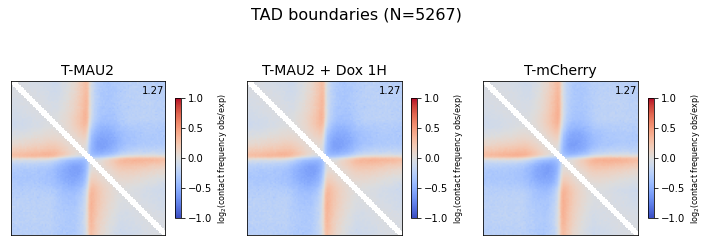

In [158]:
plt.figure(figsize = (10, 4))
plt.suptitle('TAD boundaries (N=5267)', fontsize = 16)

plt.subplot(131)
plt.title('T-MAU2', fontsize = 14)
plt.imshow(np.log2(pile1), vmin = -1, vmax = 1, cmap = 'coolwarm')
plt.text(x = 100, y = 3, s = get_boundary_strength(pile1), ha = 'right', va = 'top', fontsize = 10)
cbar = plt.colorbar(shrink = 0.5)
cbar.set_label('log$_{2}$(contact frequency obs/exp)', fontsize = 8)
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(132)
plt.title('T-MAU2 + Dox 1H', fontsize = 14)
plt.imshow(np.log2(pile1), vmin = -1, vmax = 1, cmap = 'coolwarm')
plt.text(x = 100, y = 3, s = get_boundary_strength(pile2), ha = 'right', va = 'top', fontsize = 10)
cbar = plt.colorbar(shrink = 0.5)
cbar.set_label('log$_{2}$(contact frequency obs/exp)', fontsize = 8)
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(133)
plt.title('T-mCherry', fontsize = 14)
plt.imshow(np.log2(pile3), vmin = -1, vmax = 1, cmap = 'coolwarm')
plt.text(x = 100, y = 3, s = get_boundary_strength(pile3), ha = 'right', va = 'top', fontsize = 10)
cbar = plt.colorbar(shrink = 0.5)
cbar.set_label('log$_{2}$(contact frequency obs/exp)', fontsize = 8)
plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()
plt.savefig('./paper_figures_new/tad_boundaries_1.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

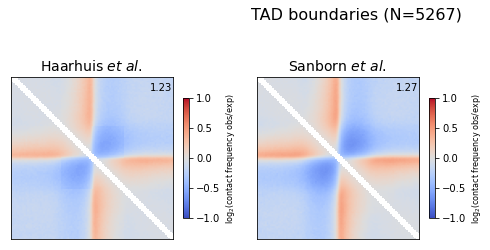

In [159]:
plt.figure(figsize = (10, 4))
plt.suptitle('TAD boundaries (N=5267)', fontsize = 16)

plt.subplot(131)
plt.title('Haarhuis $et$ $al.$', fontsize = 14)
plt.imshow(np.log2(pile4), vmin = -1, vmax = 1, cmap = 'coolwarm')
plt.text(x = 100, y = 3, s = get_boundary_strength(pile4), ha = 'right', va = 'top', fontsize = 10)
cbar = plt.colorbar(shrink = 0.5)
cbar.set_label('log$_{2}$(contact frequency obs/exp)', fontsize = 8)
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(132)
plt.title('Sanborn $et$ $al.$', fontsize = 14)
plt.imshow(np.log2(pile5), vmin = -1, vmax = 1, cmap = 'coolwarm')
plt.text(x = 100, y = 3, s = get_boundary_strength(pile5), ha = 'right', va = 'top', fontsize = 10)
cbar = plt.colorbar(shrink = 0.5)
cbar.set_label('log$_{2}$(contact frequency obs/exp)', fontsize = 8)
plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()
plt.savefig('./paper_figures_new/tad_boundaries_2.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

## Average TAD

In [140]:
def get_tad_density(pile):
    tad_density = np.mean(pile[33:66, 33:66])
    return(str(round(tad_density, 2)))

In [160]:
pile1 = pd.read_csv('./insulation/average_tads_T-MAU2.txt', skiprows = 35, sep = '\s+', header = None).values
pile2 = pd.read_csv('./insulation/average_tads_T-MAU2_Dox_1H.txt', skiprows = 35, sep = '\s+', header = None).values
pile3 = pd.read_csv('./insulation/average_tads_T-mCherry.txt', skiprows = 35, sep = '\s+', header = None).values
pile4 = pd.read_csv('./insulation/average_tads_haarhuis_2017.WT.txt', skiprows = 35, sep = '\s+', header = None).values
pile5 = pd.read_csv('./insulation/average_tads_sanborn_2015.WT.txt', skiprows = 35, sep = '\s+', header = None).values

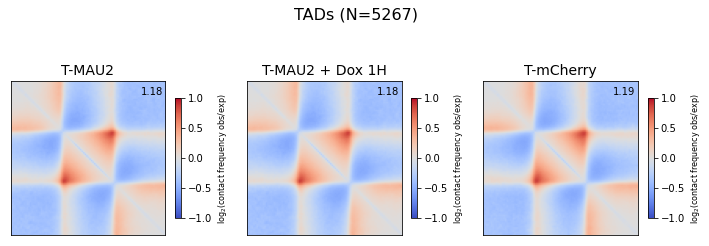

In [161]:
plt.figure(figsize = (10, 4))
plt.suptitle('TADs (N=5267)', fontsize = 16)

plt.subplot(131)
plt.title('T-MAU2', fontsize = 14)
plt.imshow(np.log2(pile1), vmin = -1, vmax = 1, cmap = 'coolwarm')
plt.text(x = 97, y = 3, s = get_tad_density(pile1), ha = 'right', va = 'top', fontsize = 10)
cbar = plt.colorbar(shrink = 0.5)
cbar.set_label('log$_{2}$(contact frequency obs/exp)', fontsize = 8)
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(132)
plt.title('T-MAU2 + Dox 1H', fontsize = 14)
plt.imshow(np.log2(pile1), vmin = -1, vmax = 1, cmap = 'coolwarm')
plt.text(x = 97, y = 3, s = get_tad_density(pile2), ha = 'right', va = 'top', fontsize = 10)
cbar = plt.colorbar(shrink = 0.5)
cbar.set_label('log$_{2}$(contact frequency obs/exp)', fontsize = 8)
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(133)
plt.title('T-mCherry', fontsize = 14)
plt.imshow(np.log2(pile3), vmin = -1, vmax = 1, cmap = 'coolwarm')
plt.text(x = 97, y = 3, s = get_tad_density(pile3), ha = 'right', va = 'top', fontsize = 10)
cbar = plt.colorbar(shrink = 0.5)
cbar.set_label('log$_{2}$(contact frequency obs/exp)', fontsize = 8)
plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()
plt.savefig('./paper_figures_new/tads_1.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

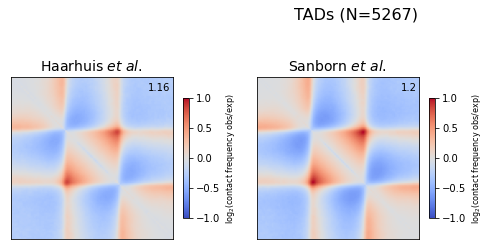

In [162]:
pile1 = pd.read_csv('./insulation/average_tads_T-MAU2.txt', skiprows = 35, sep = '\s+', header = None).values
pile2 = pd.read_csv('./insulation/average_tads_T-MAU2_Dox_1H.txt', skiprows = 35, sep = '\s+', header = None).values
pile3 = pd.read_csv('./insulation/average_tads_T-mCherry.txt', skiprows = 35, sep = '\s+', header = None).values
pile4 = pd.read_csv('./insulation/average_tads_haarhuis_2017.WT.txt', skiprows = 35, sep = '\s+', header = None).values
pile5 = pd.read_csv('./insulation/average_tads_sanborn_2015.WT.txt', skiprows = 35, sep = '\s+', header = None).values


plt.figure(figsize = (10, 4))
plt.suptitle('TADs (N=5267)', fontsize = 16)

plt.subplot(131)
plt.title('Haarhuis $et$ $al.$', fontsize = 14)
plt.imshow(np.log2(pile4), vmin = -1, vmax = 1, cmap = 'coolwarm')
plt.text(x = 97, y = 3, s = get_tad_density(pile4), ha = 'right', va = 'top', fontsize = 10)
cbar = plt.colorbar(shrink = 0.5)
cbar.set_label('log$_{2}$(contact frequency obs/exp)', fontsize = 8)
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(132)
plt.title('Sanborn $et$ $al.$', fontsize = 14)
plt.imshow(np.log2(pile5), vmin = -1, vmax = 1, cmap = 'coolwarm')
plt.text(x = 97, y = 3, s = get_tad_density(pile5), ha = 'right', va = 'top', fontsize = 10)
cbar = plt.colorbar(shrink = 0.5)
cbar.set_label('log$_{2}$(contact frequency obs/exp)', fontsize = 8)
plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()
plt.savefig('./paper_figures_new/tads_2.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()